In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from itertools import combinations

from mpmath import jtheta # needed for wrapped normal distribution


from numpy.typing import ArrayLike

### Remarks

* [wrapped normal distributions](https://mpmath.org/doc/0.19/functions/elliptic.html#jacobi-theta-functions)



### Deformation Space

Recall that the following three spaces are all diffeomorphic 

$$Q = \{ z \in \mathbb{C}^{n+1} \mid \sum_k z_k^2 = 1 \}$$

$$TS^n = \{ (x,y) \mid x \in S^n, \langle x , y \rangle = 0\}$$

$$S^n \times S^n / \Delta = \{(u,v) \mid u,v \in S^n, u \neq v \}$$

The diffeomorphism are given by 

$$\Psi \colon TS^n \to Q \quad , \quad (x,y) \mapsto (x \sqrt{1 + \lVert y \rVert^2} + i y)$$

and 

$$\Phi \colon S^n \times S^n / \Delta \to TS^n \quad , \quad (u,v) \mapsto \left(u, \frac{v - \langle u, v\rangle u}{1 - \langle u, v\rangle}\right)$$

In [ ]:
# DIFFEOMORPHISMS TS^n <-> Q <-> S^n x S^n / Delta

def Psi(p): # TS^n -> Q
    x, y = p # unpack point (into base point x, tangent vector y)

    z = x*np.sqrt(1 + np.inner(y,y)) + y*1j

    return z

def invPsi(z): # Q -> TS^n
    re, im = (z.real,z.imag) # seperate into re and im part
    
    x = re / np.sqrt(1 + np.inner(im,im))
    y = im
    
    return (x,y)

def Phi(p): # S^n x S^n / Delta -> TS^n
    u, v = p # unpack p

    x = u # base point
    y = (v - np.inner(u,v)*u) / (1 - np.inner(u,v)) # tangent vector 

    return (x,y)

def invPhi(p): # TS^n -> S^n x S^n / Delta
    x,y = p # unpack base point, tangent vector

    u = x
    v = (x*(np.inner(y,y) - 1) + 2*y ) / (np.inner(y,y) + 1)

    return u, v

# TOY MODEL ACTION FUNCTIONAL
def S(z:complex,w:complex,beta:float) -> float:
    return  beta * np.inner(z,w.conjugate()) * np.inner(w, z.conjugate())



In [18]:
def sweep_sphere(phi:list,d:int,f) -> int:  
    alpha = 0

    # LOOP OVER COMPONENTS 
    for j in range(d):
        phi_old = phi[-1] # current state 

        # SAMPLE 2x2 ROTATION ANGLE
        theta = np.random.vonmises(mu=0.0,kappa=2)

        # ROTATE COMPONENT
        zeta = np.exp(theta*1j)*phi_old[j]
        
        # PROPOSE NEW STATE
        phi_new = phi_old.copy()
        phi_new[j] = zeta
    
        # ACCEPTENCE PROBABILITIES
        A = np.minimum(1, f(phi_new) / (f(phi_old) + 1e-10) ) # 1e-10 to avoid divison by zero

        # CHECK IF ACCEPTED
        p = np.random.uniform(low=0,high=1) # draw vector of uniform rnds
        
        if p <= A : # accept if p < A
            phi.append(phi_new)
            alpha += 1
        else:
            phi.append(phi_old)

    return alpha


In [ ]:
def MCMC_toy(z0:complex,w0:complex,beta:float,N_steps:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:

    # SETUP
    z = [z0] 
    w = [w0]

    d = z0.size # dimension
    alpha = 0 # number accepted

    expSw = lambda z: np.exp( -S(z,w[-1],beta) ) # w fixed
    expSz = lambda w: np.exp( -S(z[-1],w,beta) ) # z fixed

    for _ in range(N_steps):

        alpha += sweep_sphere(phi=z,d=d,f=expSw) 
        alpha += sweep_sphere(phi=w,d=d,f=expSz)
       
    samples_z, samples_w = (np.array(z)[burnin::k], np.array(w)[burnin::k])

    acception_rate = alpha / (2*d*N_steps) 

    return (samples_z, samples_w, acception_rate)

In [44]:
z0 = np.array([1 + 0j,1j])
z0 /= np.abs(z0)
w0 = np.array([1 + 0j,1j])
w0 /= np.abs(z0)

N = 10_000

t0 = time.time()

obs = []

Nbeta = 1_000

for beta in range(1,Nbeta):

    z_samples, w_samples, alpha = MCMC_toy(z0,w0,beta,N,burnin=200,k=5)
    obs.append(S(z_samples,w_samples,beta).real.mean()/beta)

    print(f'{beta}/{Nbeta}',end='\r')


print(f'running time: {time.time() - t0:.2f}s')



running time: 430.76s


Text(0, 0.5, '$S/\\beta$')

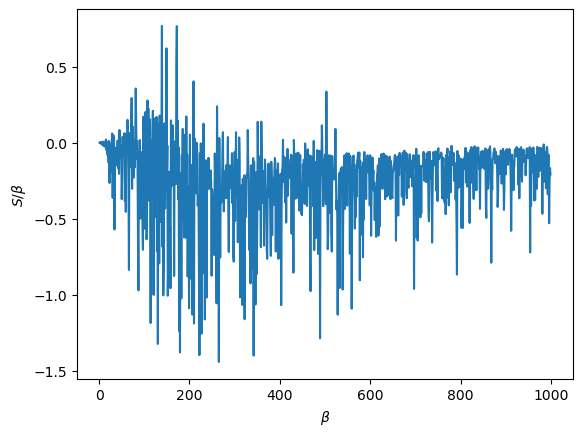

In [ ]:
beta = range(1,Nbeta)
plt.plot(beta,obs)
plt.xlabel(f'$\\beta$')
plt.ylabel(f'$S/\\beta$');

## Tests

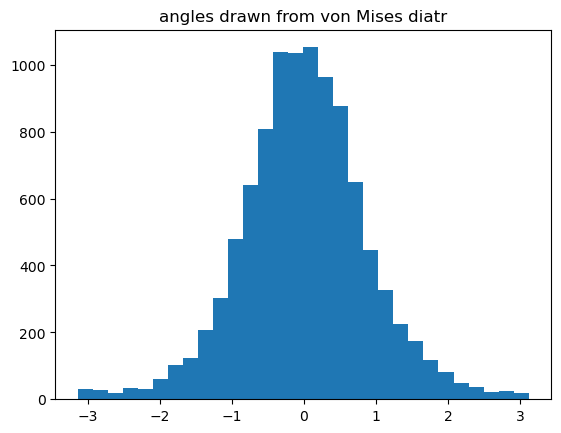

In [52]:
data = np.random.vonmises(0.0,2,size=10_000)
plt.hist(data,bins=30)
plt.title('angles drawn from von Mises diatr');

In [53]:
# TESTING DIFFS
x = np.array([1,0,0])
y = np.array([0,1,0])

u = np.array([1,0,0])
v = np.array([0,1,0])

z = 1 + 2j

x_prime,y_prime = invPsi(Psi((x,y)))
print(f'{x_prime - x = }')
print(f'{y_prime - y = }')

w = Psi(invPsi(z))
print(f'{w - z = }')

x_prime - x = array([0., 0., 0.])
y_prime - y = array([0., 0., 0.])
w - z = 0j
